In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as p
import keras
from keras.models import Sequential
from keras.layers import Dense

nTrain = 50000 # set number of training events
nEval = 50000 # set num#ber of test event

PATH = "C:\\Users\\reubenosborne\\Documents\\Python Scripts"
DATA = "HLTCSVMonitor_2.csv"

targetColumns = [ "HLT1_MVA" ] # use the global "pass" variable to start

inputVarsContinuous = [ 'nVelo' 
                        ,'nTT'
                        ,'nIT'
                        ,'nOT'
                        ,'nPV'#
                        ,'nSPD'
                        ,'nECAL' 
                        ,'nHCAL'
                        ,'nM1'#
                        ,'nM2' #
                        ,'nM3'
                        ,'nM4'
                        ,'nM5' 
                        ,'nVeloTrk'#
                        ,'nVTTTracks'
                        ,'nForwardTracks'#
                        ,'nFittedTracks'#
                        ,'usedVelo'#
                        ,'usedTT'
                        ,'usedIT'
                        ,'usedOT'
                        ,'pv0NTrack'
                        ,'pv0Chi2ndf'
                        ,'pv1NTrack'
                        ,'pv1Chi2ndf'
                        ,'IP_trk0'#
                        ,'IPChi2_trk0'#
                        ,'p_trk0'
                        ,'pT_trk0'
                        ,'ghostProb_trk0'
                        ,'IP_trk1'
                        ,'IPChi2_trk1'
                        ,'p_trk1'
                        ,'pT_trk1'
                        ,'ghostProb_trk1'
                        ,'IP_trk2'
                        ,'IPChi2_trk2'
                        ,'p_trk2'
                        ,'pT_trk2'
                        ,'ghostProb_trk2'
                        ,'IP_trk3'
                        ,'IPChi2_trk3'
                        ,'p_trk3'
                        ,'pT_trk3'
                        ,'ghostProb_trk3'
    ]
        
dataset = pd.read_csv(os.path.join(PATH,DATA), usecols = inputVarsContinuous+targetColumns,
                      skipinitialspace=True, nrows=nTrain+nEval)

#Data manipulation - removing unwanted events
df = pd.DataFrame(dataset)
df = df[df.nPV != 0]
df = df[df.IP_trk0 !=-999]
df = df[df.IP_trk1 !=-999]
df = df[df.IP_trk2 !=-999]
df = df[df.IP_trk3 !=-999]
df['HLT1_MVA'] = (df['HLT1_MVA']>0).astype(int)

#Target in matrix form for Keras
y1 = df['HLT1_MVA']
y=y1.as_matrix()
del df['HLT1_MVA']
dataset=df

#Input Normalisation
for v in list(dataset):
    
    a = np.abs(((dataset[v]-dataset[v].mean())/dataset[v].std()).skew())
    b = np.abs((np.log1p(dataset[v])).skew())
    c = np.abs((dataset[v].skew()))

    if a<=b and a<=c:
        dmean = dataset[v].mean()
        dstd = dataset[v].std()
        dataset[v]=(dataset[v]-dmean)/dstd
        
    elif b<=a and b<=c:
        dataset[v]=np.log1p(dataset[v])

#Input dataset in martix form for Keras
x=dataset.as_matrix()

#Setting Training data and Evaluation data
nTrain = int(len(x)/2)
nEval = len(x)-nTrain
x_train = x[0:nTrain]
y_train = y[0:nTrain]
x_eval = x[nTrain:nTrain+nEval]
y_eval = y[nTrain:nTrain+nEval]


nVal= len(x[0])

#Data Generator to address class imbalance
class DataGenerator(object):
    """Generates data for Keras"""
    def __init__(self, x, y, batch_size = 32, shuffle = True):
        """Initlaization of the data generator"""
        self.x_pass = x[y==1] # use y==1 as a boolean array to select from x
        self.x_fail = x[y==0] # use y==0 as a boolean array to select from x
        self.batch_size = batch_size
        self.shuffle = shuffle
        print("Number of passing events {}, failing {}, batch size {}".\
              format(len(self.x_pass),len(self.x_fail),self.batch_size))

    def genPass(self,num):
        """Generates batches of samples of pass events"""
        # Infinite loop
        while 1:
            # Generate order of exploration of dataset
            if( self.shuffle): 
                np.random.shuffle(self.x_pass)    
            imax = int(len(self.x_pass)/num)
            for i in range(imax):
                # Generate data
                x = self.x_pass[i*num:(i+1)*num]
                yield x

    def genFail(self,num):
        """Generates batches of samples of fail events"""
        # Infinite loop
        while 1:
            # Generate order of exploration of dataset
            if( self.shuffle): 
                np.random.shuffle(self.x_fail) 
            imax = int(len(self.x_fail)/num)
            for i in range(imax):
                # Generate data
                x = self.x_fail[i*num:(i+1)*num]
                yield x
                
    def generate(self):
        """Generates the equally weighted pass/fail"""
        num = self.batch_size//2
        if(len(self.x_pass)<num):
            numPass = len(self.x_pass)
            print("Not enough pass events, setting to {} per batch step".format(numPass))
        else:
            numPass = num
        if(len(self.x_fail)<num):
            numFail = len(self.x_fail)
            print("Not enough fail events, setting to {} per batch step".format(numFail))
        else:
            numFail = num
        # make the generators
        genPass = self.genPass(numPass)
        genFail = self.genFail(numFail)
        yInit = np.concatenate([np.ones(numPass),np.zeros(numFail)])
        while 1:
            x = np.concatenate([next(genPass),next(genFail)]) # get num pass events
            xy = np.c_[x,yInit] # merge x&y into a single array
            ### note get numPass pass events then numFail fail events 
            yield xy[:,:-1], xy[:,-1:] # x is all but last and y is last column

# test the generator: create a generator
batchSize = 16# a test value, change to see how generator responds
g = DataGenerator(x=x_train,y=y_train,batch_size=batchSize,shuffle=True).generate()
x,y = next(g) # run the generator for one batchSize of events
print("Num evts in batch = {},\n first 3 events\nx={}\n and last 3 \nx={}".format(len(x),np.c_[x[:3],y[:3]],np.c_[x[-3:],y[-3:]]))




Using TensorFlow backend.


['nVelo', 'nTT', 'nIT', 'nOT', 'nSPD', 'nECAL', 'nHCAL', 'nM1', 'nM2', 'nM3', 'nM4', 'nM5', 'nVeloTrk', 'nVTTTracks', 'nForwardTracks', 'nFittedTracks', 'usedVelo', 'usedTT', 'usedIT', 'usedOT', 'nPV', 'pv0NTrack', 'pv0Chi2ndf', 'pv1NTrack', 'pv1Chi2ndf', 'IP_trk0', 'IPChi2_trk0', 'p_trk0', 'pT_trk0', 'ghostProb_trk0', 'IP_trk1', 'IPChi2_trk1', 'p_trk1', 'pT_trk1', 'ghostProb_trk1', 'IP_trk2', 'IPChi2_trk2', 'p_trk2', 'pT_trk2', 'ghostProb_trk2', 'IP_trk3', 'IPChi2_trk3', 'p_trk3', 'pT_trk3', 'ghostProb_trk3']
Number of passing events 4066, failing 41384, batch size 16
Num evts in batch = 16,
 first 3 events
x=[[  7.80180040e+00   6.91274282e+00   6.13988455e+00   8.64470651e+00
    5.79301361e+00   6.74405919e+00   5.55682806e+00   5.93489420e+00
    4.04305127e+00   4.02535169e+00   2.39789527e+00   1.60943791e+00
    5.08759634e+00   4.44265126e+00   2.99573227e+00   3.13549422e+00
    5.69373214e+00   4.41884061e+00  -2.48496812e-02   5.94017125e+00
    6.93147181e-01   4.54329478e

Initial loss: 0.345261466334
Inital accuracy: 0.911751116594
Number of passing events 4066, failing 41384, batch size 16
Epoch 1/300
2840/2840 [==============================] - 7s 3ms/step - loss: 0.4907 - acc: 0.7704
Epoch 2/300
2840/2840 [==============================] - 8s 3ms/step - loss: 0.4277 - acc: 0.8122
Epoch 3/300
2840/2840 [==============================] - 7s 3ms/step - loss: 0.4088 - acc: 0.8233
Epoch 4/300
2840/2840 [==============================] - ETA: 0s - loss: 0.3978 - acc: 0.830 - 7s 3ms/step - loss: 0.3975 - acc: 0.8312
Epoch 5/300
2840/2840 [==============================] - 7s 2ms/step - loss: 0.3879 - acc: 0.8366
Epoch 6/300
2840/2840 [==============================] - 7s 3ms/step - loss: 0.3819 - acc: 0.8384
Epoch 7/300
2840/2840 [==============================] - 8s 3ms/step - loss: 0.3727 - acc: 0.8456
Epoch 8/300
2840/2840 [==============================] - 8s 3ms/step - loss: 0.3689 - acc: 0.8473
Epoch 9/300
2840/2840 [==============================] - 

2840/2840 [==============================] - 6s 2ms/step - loss: 0.2802 - acc: 0.8859
Epoch 82/300
2840/2840 [==============================] - 6s 2ms/step - loss: 0.2815 - acc: 0.8858
Epoch 83/300
2840/2840 [==============================] - 5s 2ms/step - loss: 0.2820 - acc: 0.8846
Epoch 84/300
2840/2840 [==============================] - 7s 2ms/step - loss: 0.2809 - acc: 0.8849
Epoch 85/300
2840/2840 [==============================] - 6s 2ms/step - loss: 0.2762 - acc: 0.8908
Epoch 86/300
2840/2840 [==============================] - 6s 2ms/step - loss: 0.2822 - acc: 0.8862A: 0s - loss: 0.2830 - acc: 0.8
Epoch 87/300
2840/2840 [==============================] - 6s 2ms/step - loss: 0.2778 - acc: 0.8867
Epoch 88/300
2840/2840 [==============================] - 6s 2ms/step - loss: 0.2800 - acc: 0.8870
Epoch 89/300
2840/2840 [==============================] - 6s 2ms/step - loss: 0.2761 - acc: 0.8871
Epoch 90/300
2840/2840 [==============================] - 6s 2ms/step - loss: 0.2799 - acc:

2840/2840 [==============================] - 5s 2ms/step - loss: 0.2581 - acc: 0.8955
Epoch 163/300
2840/2840 [==============================] - 6s 2ms/step - loss: 0.2594 - acc: 0.8957
Epoch 164/300
2840/2840 [==============================] - 6s 2ms/step - loss: 0.2589 - acc: 0.8955
Epoch 165/300
2840/2840 [==============================] - 5s 2ms/step - loss: 0.2603 - acc: 0.8948
Epoch 166/300
2840/2840 [==============================] - 6s 2ms/step - loss: 0.2593 - acc: 0.8967
Epoch 167/300
2840/2840 [==============================] - 6s 2ms/step - loss: 0.2577 - acc: 0.8978
Epoch 168/300
2840/2840 [==============================] - 6s 2ms/step - loss: 0.2634 - acc: 0.8939
Epoch 169/300
2840/2840 [==============================] - 6s 2ms/step - loss: 0.2559 - acc: 0.8965
Epoch 170/300
2840/2840 [==============================] - 6s 2ms/step - loss: 0.2622 - acc: 0.8945A: 0s - loss: 0.2614 - acc:
Epoch 171/300
2840/2840 [==============================] - 5s 2ms/step - loss: 0.2575 -

2840/2840 [==============================] - 6s 2ms/step - loss: 0.2491 - acc: 0.8991
Epoch 244/300
2840/2840 [==============================] - 6s 2ms/step - loss: 0.2516 - acc: 0.8986
Epoch 245/300
2840/2840 [==============================] - 6s 2ms/step - loss: 0.2464 - acc: 0.8994
Epoch 246/300
2840/2840 [==============================] - 6s 2ms/step - loss: 0.2529 - acc: 0.8981
Epoch 247/300
2840/2840 [==============================] - 6s 2ms/step - loss: 0.2504 - acc: 0.8997
Epoch 248/300
2840/2840 [==============================] - 6s 2ms/step - loss: 0.2523 - acc: 0.8982
Epoch 249/300
2840/2840 [==============================] - 6s 2ms/step - loss: 0.2485 - acc: 0.9002
Epoch 250/300
2840/2840 [==============================] - 6s 2ms/step - loss: 0.2512 - acc: 0.8987
Epoch 251/300
2840/2840 [==============================] - 6s 2ms/step - loss: 0.2515 - acc: 0.8993A: 1s - los
Epoch 252/300
2840/2840 [==============================] - 6s 2ms/step - loss: 0.2464 - acc: 0.9014
Epo

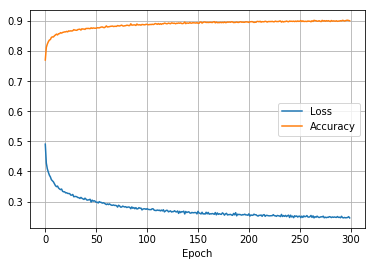

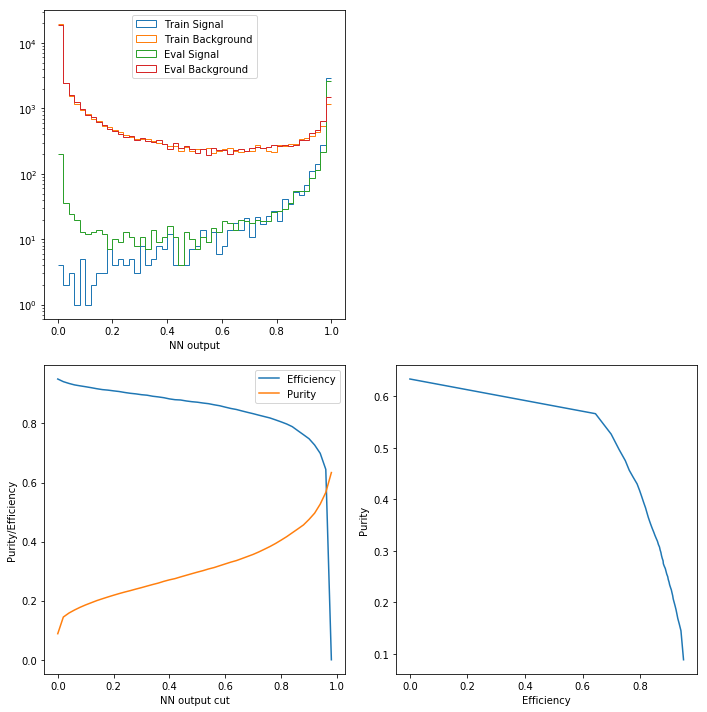

           Training sample NN>0.5
           | True Fail  | True Pass  |
--------------------------------------
NN Fail    |      33577 |        115 |
NN Pass    |       7806 |       3951 |

           Evaluation sample NN>0.5
           | True Fail  | True Pass  |
--------------------------------------
NN Fail    |      33135 |        506 |
NN Pass    |       8306 |       3503 |


In [5]:
model = Sequential()
model.add(Dense(nVal, activation='elu', input_dim=nVal))
model.add(Dense(nVal, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adadelta',
              loss='binary_crossentropy',
              metrics=['accuracy'])

score = model.evaluate(x_eval, y_eval, verbose=0)
print('Initial loss:', score[0])
print('Inital accuracy:', score[1])

batchSize = 16
history=model.fit_generator(generator = DataGenerator(x=x_train,y=y_train,batch_size=batchSize,shuffle=True).generate(),
                            steps_per_epoch = len(x_train)//batchSize,
                            verbose=1,
                            epochs=300)
score = model.evaluate(x_eval, y_eval, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])




%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(history.epoch,history.history['loss'],label="Loss")
plt.plot(history.epoch,history.history['acc'],label='Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.grid()
plt.show()
outComp = np.zeros((2,2))
y_predTrain = model.predict(x_train)
y_predEval = model.predict(x_eval)
bins = np.linspace(0,1.,51)

fig = plt.figure(figsize=(10,10))
p = plt.subplot(2,2,1)
hTrueTrain = p.hist(y_predTrain[y_train.astype(np.bool)],bins=bins,histtype='step',label='Train Signal')
hFalseTrain = p.hist(y_predTrain[np.logical_not(y_train.astype(np.bool))],bins=bins,histtype='step',label='Train Background')
hTrueEval = p.hist(y_predEval[y_eval.astype(np.bool)],bins=bins,histtype='step',label='Eval Signal')
hFalseEval = p.hist(y_predEval[np.logical_not(y_eval.astype(np.bool))],bins=bins,histtype='step',label='Eval Background')
p.legend(loc=9)
p.semilogy()
p.set_xlabel('NN output')

totTrueEval = np.sum(hTrueEval[0])
totFalseEval = np.sum(hFalseEval[0]) 
chTrueEval = totTrueEval - np.cumsum(hTrueEval[0])
chFalseEval = totFalseEval - np.cumsum(hFalseEval[0])

purity = np.zeros((len(bins)-1,))
purity[0] = totTrueEval/(totFalseEval + totTrueEval)
purity[1:] = [i for i in (chTrueEval[:-1])/(chTrueEval[:-1]+chFalseEval[:-1])]

efficiency = chTrueEval/totTrueEval

p = plt.subplot(2,2,3)
p.plot(bins[:-1],efficiency,label='Efficiency')
p.plot(bins[:-1],purity,label='Purity')
p.set_xlabel('NN output cut')
p.set_ylabel('Purity/Efficiency')
p.legend()
p = plt.subplot(2,2,4)
p.plot(efficiency,purity,label='ROC')
p.set_xlabel('Efficiency')
p.set_ylabel('Purity')
plt.tight_layout()
plt.show()

outCompTrain = np.zeros((2,2))
cut = 0.5
for i in range(nTrain-1):
    p1 = np.int(y_predTrain[i]>0.5)
    p2 = np.int(y_train[i]>0)
    #print(i,p1,p2)
    outCompTrain[p1,p2] += 1

outCompEval = np.zeros((2,2))
for i in range(nEval-1):
    p2 = np.int(y_eval[i]>0)
    outCompEval[np.int(y_predEval[i]>0.5),p2] += 1

def printTrueTable(header,outComp):
    print('           {:20s}'.format(header))
    print('{:10s} | {:10s} | {:10s} |'.format('','True Fail','True Pass'))
    print('{:38s}'.format(''.join(['-']*38)))
    print('{:10s} | {:10.0f} | {:10.0f} |'.format('NN Fail',outComp[0,0],outComp[0,1]))
    print('{:10s} | {:10.0f} | {:10.0f} |'.format('NN Pass',outComp[1,0],outComp[1,1]))
    
printTrueTable('Training sample NN>{}'.format(cut),outCompTrain)
print()
printTrueTable('Evaluation sample NN>{}'.format(cut),outCompEval)

In [3]:
l0=model.layers[0]
l0.get_weights()

[array([[ 0.27459276, -0.07724136,  0.0444119 , ..., -0.69819564,
          0.03196293, -0.14879368],
        [-0.09689641, -0.05684279,  0.09154708, ...,  0.28994852,
          0.02174268, -0.00803516],
        [-0.34697574, -0.0761679 , -0.1633743 , ..., -0.39354393,
         -0.14195466,  0.10200681],
        ..., 
        [ 0.55415452, -0.21423167,  0.02704372, ...,  0.25001296,
         -0.23834372, -0.06336979],
        [ 0.65680575,  0.06430626,  0.05055296, ...,  0.19266035,
          0.05137189, -0.20157178],
        [ 0.28759661,  0.00327742,  0.11508877, ...,  0.47330746,
          0.57720625, -0.00985375]], dtype=float32),
 array([ 0.15303989,  0.        ,  0.14086531,  1.57528222,  1.01597643,
        -2.04763865, -0.27475432, -0.29139602, -0.54821289, -0.0081908 ,
        -0.515432  ,  0.        ,  0.        ,  1.15119445,  0.        ,
        -1.92799628,  0.        , -0.04526452,  1.0449245 , -1.05370605,
         0.29277018,  0.        ,  0.        ,  0.57615131, -0.01